In [1]:
import mbuild as mb
from openff.toolkit.topology import Molecule
import random
import numpy
import random
import warnings
warnings.filterwarnings("ignore")

octet = {        6 : 4, 7 : 3,1 : 1,8 : 2,16 : 2}
atom_type = {6:"C",7:"N",8:"O",1:"H",16:"S"}

class MadAtom():
    
    def check_happy(self):
        if self.desired_order == self.current_order:
            self.happy = True
            return
        self.happy= False
    
    def add_order(self,o):
        self.current_order += o
        self.check_happy()
        for b in self.bonds:
            b.check_done()
    
    def status(self):
        return self.desired_order - self.current_order
    
    def __str__(self):
        return "{}{}: {}-{}, {}".format(atom_type[self.atomic_number],self.index,self.desired_order,self.current_order,self.happy)
    
    def __init__(self, i, an, do, co ):
        self.index = i
        self.atomic_number = an
        self.desired_order = do 
        self.current_order = co
        self.happy = False
        self.check_happy()
        self.bonds = []

class MadBond():
    def __init__(self,a1,a2,bo,i):
        self.atom1 = a1
        self.atom2 = a2
        self.order = bo
        self.happy = False
        self.index = i
        
    def __repr__(self):
        return "Bond {} {}{}-{}{} O={}, {}. ".format(self.index,atom_type[self.atom1.atomic_number],self.atom1.index,atom_type[self.atom2.atomic_number],self.atom2.index,self.order,self.happy)
    
    def check_done(self):
        if self.atom1.atomic_number == 1:
            self.happy = True
            return
        if self.atom2.atomic_number == 1:
            self.happy = True
            return
        if self.atom1.happy and self.atom2.happy:
            self.happy = True
            return
        self.happy = False
    
    def add_order(self,o):
        self.order += o
        self.atom1.add_order(o)
        self.atom2.add_order(o)
        self.check_done()
        
class BondWalker():

    def __init__(self, mol):
        self.mol = mol
        self.atom_list = []
        for atom in mol.atoms:
            self.atom_list.append(MadAtom(atom.molecule_atom_index, atom.atomic_number, octet[atom.atomic_number], len([b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]) )) #assumes we have no double bonds at the start
        self.bond_list = [MadBond(self.atom_list[b.atom1_index],self.atom_list[b.atom2_index],b.bond_order,i) for i,b in enumerate(mol.bonds)] # .bond_order inside each of these, and can use atom1_index atom2_index
        for b in self.bond_list: 
            b.atom1.bonds.append(b)
            b.atom2.bonds.append(b)
            b.check_done()
            
    def done(self):
        for i in self.atom_list:
            if i.happy == False:
                return False
        for i in self.bond_list:
            if i.happy == False:
                return False
        return True
    
    def bond_increasable(self, b):
        if not b.atom1.happy and not b.atom2.happy:
            if b.atom1.status() > 0:
                if b.atom2.status() >0:
                    b.add_order(1) #this triggers each atom to increment, and *their* bonds to check happiness
                    if self.done():
                        return True
                    for a in self.atom_list:
                        if a.happy == False:
                            for bx in a.bonds:
                                if self.bond_increasable(bx):
                                    return True
                            #no bonds around this unhappy atom "a" are increasable
                            b.add_order(-1)
                            return False
                        
    def fill_in_bonds(self):        
        for a in self.atom_list: #since some of the unhappy bonds might end up being OK, let's iterate atoms
            if a.happy == False:
                for b in a.bonds: #try incrementing every bond around every unhappy atom
                    if self.bond_increasable(b):
                        print("Done!")
                        for b1,b2 in zip(self.bond_list, self.mol.bonds):
                            b2.bond_order=b1.order 
                        return self.mol
        print("Sorry- I couldn't solve this")

Done!


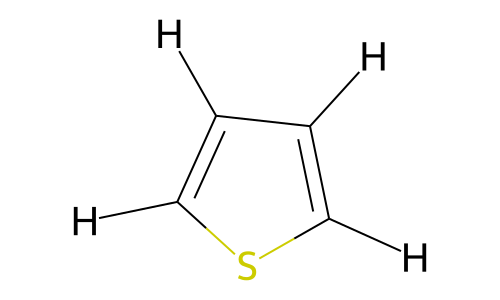

In [2]:
thiophene = mb.load("c1ccsc1",smiles=True)
thiophene.save("thio.sdf",overwrite=True)
b= BondWalker(Molecule.from_file("thio.sdf",file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()

Done!


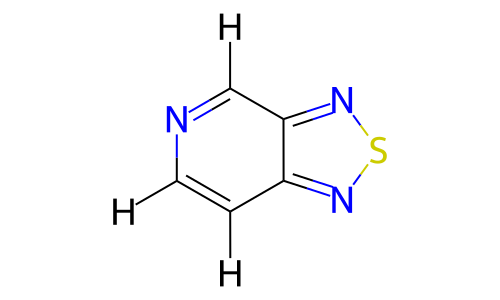

In [3]:
b= BondWalker(Molecule.from_file("pt.sdf",file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()